In [1]:
import os, sys
import numpy as np
import json
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD, Adam
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import datetime


## Preliminary

In [2]:
torch.manual_seed(12345)
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')

na_list = ['A', 'C', 'G', 'T'] #nucleic acids
aa_list = ['R', 'L', 'S', 'A', 'G', 'P', 'T', 'V', 'N', 'D', 'C', 'Q', 'E', 'H', 'I', 'K', 'M', 'F', 'W', 'Y'] #amino acids
NNK_freq = [0.09375]*3 + [0.0625]*5 + [0.03125]*13 #freq of 21 NNK codons including the stop codon
sum_20 = 0.0625*5 + 0.09375*3 + 0.03125*12 #sum of freq without the stop codon
pvals = [0.09375/sum_20]*3 + [0.0625/sum_20]*5 + [0.03125/sum_20]*12 #normalize freq for 20 codons
pvals = [0.09375/sum_20]*3 + [0.0625/sum_20]*5 + [0.03125/sum_20]*11 + \
        [1- sum([0.09375/sum_20]*3 + [0.0625/sum_20]*5 + [0.03125/sum_20]*11)] 
        #adjust sum to 1 due to numerical issue
aa_dict = dict(zip(aa_list, pvals))
k = 1000

## Dataset

In [3]:
def construct_dataset():
    with open(aptamer_dataset_file, 'r') as f:
        aptamer_data = json.load(f)
    full_dataset = []
    for aptamer in aptamer_data:
        peptides = aptamer_data[aptamer]
        if aptamer == "CTTTGTAATTGGTTCTGAGTTCCGTTGTGGGAGGAACATG": #took out aptamer control
            continue
        for peptide, _ in peptides:
            peptide = peptide.replace("_", "") #removed stop codons
            if "RRRRRR" in peptide: #took out peptide control
                continue
            if len(aptamer) == 40 and len(peptide) == 8: #making sure right length
                full_dataset.append((aptamer, peptide))
    full_dataset = list(set(full_dataset)) #removed duplicates
    return full_dataset

class TrainDataset(torch.utils.data.Dataset):
    def __init__(self, training_set):
        super(TrainDataset, self).__init__() 
        self.training_set = training_set
        
    def __len__(self):
        return len(self.training_set)

    def __getitem__(self, idx):
        aptamer, peptide = self.training_set[idx]
        return aptamer, peptide
    

aptamer_dataset_file = "../data/aptamer_dataset.json"
full_dataset = construct_dataset()
n = len(full_dataset)
training_set = full_dataset[:int(0.8*n)]
test_set = full_dataset[int(0.8*n):]
train_dataset = TrainDataset(training_set)
train_loader = torch.utils.data.DataLoader(train_dataset)

## NN Model

In [4]:
class SimpleConvNet(nn.Module):
    def __init__(self):
        super(SimpleConvNet, self).__init__()
        self.cnn_apt_1 = nn.Conv2d(1, 120, (4,4)) #similar to 4-gram
        self.cnn_pep_1 = nn.Conv2d(1, 50, (4,20))
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(4690, 1)
        
    def forward(self, apt, pep):
        apt = self.cnn_apt_1(apt)
        apt = self.relu(apt)
        pep = self.cnn_pep_1(pep)
        pep = self.relu(pep)
        apt = apt.view(-1, 1).T
        pep = pep.view(-1, 1).T
        
        x = torch.cat((apt, pep), 1)
        x = self.fc1(x)
        x = torch.sigmoid(x)
        return x

def weights_init(m):
    if isinstance(m, nn.Conv2d):
        nn.init.xavier_uniform_(m.weight.data)
        nn.init.zeros_(m.bias.data)
    if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight.data, nonlinearity='relu')
        nn.init.zeros_(m.bias.data)

## Sampling methods

In [5]:
# Sample x from P_X (assume apatamers follow uniform)
def get_x():
    x_idx = np.random.randint(0, 4, 40)
    x = ""
    for i in x_idx:
        x += na_list[i]
    return x

# Sample y from P_y (assume peptides follow NNK)
def get_y():
    y_idx = np.random.choice(20, 7, p=pvals)
    y = "M"
    for i in y_idx:
        y += aa_list[i]
    return y

# S' contains S with double the size of S (domain for Importance Sampling)
# Return S_prime, and S_new (all unseen samples)
def get_S_prime(k):
    S_prime_dict = dict.fromkeys(training_set, 0) #indicator 0 means in the original dataset
    S_new = []
    for _ in range(k):
    
        pair = (get_x(), get_y())
        S_prime_dict[pair] = 1 #indicator 1 means not in the original dataset
        S_new.append(pair)
    while len(S_new) < 10 * k:
        pair = (get_x(), get_y())
        S_new.append(pair)
    S_prime = [[k,int(v)] for k,v in S_prime_dict.items()]
    random.shuffle(S_prime)
    return S_prime, S_new

# Returns pmf of an aptamer
def get_x_pmf():
    return 0.25**40

# Returns pmf of a peptide
def get_y_pmf(y):
    pmf = 1
    for char in y[1:]: #skips first char "M"
        pmf *= aa_dict[char]
    return pmf


S_prime, S_new = get_S_prime(n) #use for sgd and eval
print("Length of S_new: ", len(S_new))

('Length of S_new: ', 5913090)


## Helper methods

In [6]:
## Takes a peptide and aptamer sequence and converts to one-hot matrix
def one_hot(sequence, seq_type='peptide'):
    if seq_type == 'peptide':
        letters = aa_list
    else:
        letters = na_list
    one_hot = np.zeros((len(sequence), len(letters)))
    for i in range(len(sequence)):
        char = sequence[i]
        for _ in range(len(letters)):
            idx = letters.index(char)
            one_hot[i][idx] = 1
    return one_hot

# Convert a pair to one-hot tensor
def convert(apt, pep): 
    apt = one_hot(apt, seq_type='aptamer') #(40, 4)
    pep = one_hot(pep, seq_type='peptide') #(8, 20)
    apt = torch.FloatTensor(np.reshape(apt, (1, 1, apt.shape[0], apt.shape[1]))).cuda() #(1, 1, 40, 4)
    pep = torch.FloatTensor(np.reshape(pep, (1, 1, pep.shape[0], pep.shape[1]))).cuda() #(1, 1, 8, 20)
    return apt, pep

def update(x, y):
    pmf = get_y_pmf(y)
    x.requires_grad=True
    y.requires_grad=True
    x = x.cuda()
    y = y.cuda()
    out = model(x, y)
    return pmf, out

def generate_loss_samples(k, dataset='train'):
    if dataset == 'train':
        dset = training_set
    elif dataset == 'test':
        dset = test_set
    else:
        dset = S_new
    pairs = []
    for (apt, pep) in dset[:k]:
        x, y = convert(apt, pep)
        pairs.append((x, y))
    return pairs

train_loss_samples = generate_loss_samples(k, 'train')
test_loss_samples = generate_loss_samples(k, 'test')
eval_loss_samples = generate_loss_samples(k, 's_prime')
    
def get_log_out(dataset='train'):
    outs = []
    if dataset == 'train':
        dset = train_loss_samples
    else:
        dset = test_loss_samples
    for (apt, pep) in dset:
        _, out = update(apt, pep)
        outs.append(torch.log(out).cpu().detach().numpy().flatten()[0])
    return np.average(outs)

def get_out_prime():
    outs = []
    for (apt, pep) in eval_loss_samples:
        _, out = update(apt, pep)
        outs.append(out.cpu().detach().numpy().flatten()[0])
    return np.average(outs)

# AUC Plot
def cdf(scores1, scores2, i): # i is the index
    _, ax = plt.subplots()
    ax.hist(scores1, 100, histtype='step', density=True, cumulative=True, color='red', label='train cdf')
    ax.hist(scores2, 100, histtype='step', density=True, cumulative=True, color='black', label='test cdf')
    ax.legend()
    plt.show()

## SGD

In [7]:
def sgd(t=1, #num of iter over the training set
        lamb=1e-1, #hyperparam
        gamma=1e-2): #step size
    train_correct = 0
    test_correct = 0
    optim = SGD(model.parameters(), lr=gamma)
    for _ in range(t):
        for i, (apt, pep) in enumerate(tqdm.tqdm(train_loader)):
            # Start timer here
            if i == 0:
                continue
            model.train()
            
            optim.zero_grad() #reset gradients after update
            
            x, y = convert(apt[0], pep[0]) #sample x,y from training set S
            _, out = update(x, y) #get train score
            log_out = torch.log(out) #take log
            
            
            train_score = out.cpu().detach().numpy().flatten()[0] #get score in float
            if train_score > 0.75:
                train_correct += 1 #contribute to train recall
            train_recall_outputs.append(train_score) #store the train scores
            
            optim.zero_grad() #reset gradients for the second branch
            
            x_prime, y_prime = convert(S_prime[i][0][0], S_prime[i][0][1]) #sample x', y' from S'
            y_pmf, out_prime = update(x_prime, y_prime) #get score'
            out_prime = out_prime*y_pmf*get_x_pmf()*2*n #adjust for IS
            
            const = S_prime[i][1] #indicator
            (lamb*const*out_prime - log_out).backward(retain_graph=True) #backprop
            optim.step() #gradient update
            
            
            if i < int(0.2*n): #check if idx out of range
                model.eval()
                x_test, y_test = convert(test_set[i][0], test_set[i][1]) #sample x,y from test set
                test_score = model(x_test, y_test).cpu().detach().numpy().flatten()[0] #get test score in float
                test_recall_outputs.append(test_score) #store the test scores
                if test_score > 0.75:
                    test_correct += 1 #contribute to test recall
            else:
                test_correct += 1
            #generate 10 unseen examples from S_new as compared 1 example from validate/train for cdfs
            for x, y in S_new[-(10*i+1):9-10*i]:
                x_eval, y_eval = convert(x, y) #generate unseen x'' and y''
                score_eval = model(x_eval, y_eval).cpu().detach().numpy().flatten()[0] #get unknown score
                eval_unknown_outputs.append(score_eval) #store the unknown scores

            if i % 500 == 0:
                out_prime = get_out_prime()
                train_loss = lamb*out_prime - get_log_out('train') #training loss
                test_loss = lamb*out_prime - get_log_out('test') #test loss
                train_losses.append(train_loss)
                test_losses.append(test_loss)
                train_recall = 100*train_correct/i #training recall
                train_recalls.append(train_recall) 
                test_recall = 100*test_correct/i #test recall
                test_recalls.append(test_recall)
                
                train_score = np.asarray(eval_unknown_outputs + train_recall_outputs) #combine train and unknown scores
                test_score = np.asarray(eval_unknown_outputs + test_recall_outputs) #combibne test and unknown scores
                train_cdf = np.sum(np.cumsum(train_score), dtype=float)/(np.sum(train_score)*len(train_score)) #train cdf
                test_cdf = np.sum(np.cumsum(test_score), dtype=float)/(np.sum(test_score)*len(test_score)) #test cdf
                train_cdfs.append(train_cdf)
                test_cdfs.append(test_cdf)
                
                
            if i % 10000 == 0:
                _, ax = plt.subplots()
                T = [i for i in range(501, i, 100000//500)]
                ax.plot(train_losses, 'g', label='Train loss')
                ax.plot(test_losses, 'p', label='Test loss')
                ax.plot(train_recalls, 'b', label='Train recall')
                ax.plot(test_recalls, 'y', label='Test recall')
                ax.legend()
                g = gammas[j//len(lambdas)]
                l = lambdas[j%len(lambdas)]
                ax.set_title('lambda =%.5f' % l  + ' gamma =%.5f' % g)
                plt.show()
                print("Train cdfs: ", train_cdfs[-2])
                print("Test cdfs: ", test_cdfs[-2])
                print("Train scores unkown: ", train_score[:2])
                print("Train scores train: ", train_score[-2:])
                print("Test scores unkown: ", test_score[:2])
                print("Test scores train: ", test_score[-2:])
                cdf(train_score, test_score, j)


## Hyperparameter tuning

In [8]:
gammas = [1e-2]
lambdas = [1e-1, 1e-3, 10, 100, 1e-5]
j = 0

  2%|▏         | 9994/473047 [08:46<3:23:57, 37.84it/s] 

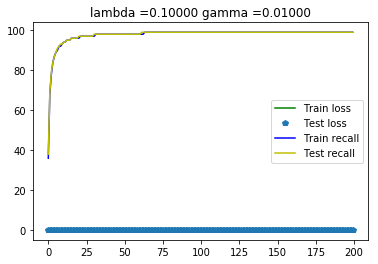

('Train cdfs: ', 0.4990922261871864)
('Test cdfs: ', 0.4990899845683071)
('Train scores unkown: ', array([0.49993682, 0.49361292], dtype=float32))
('Train scores train: ', array([0.999907, 0.999938], dtype=float32))
('Test scores unkown: ', array([0.49993682, 0.49361292], dtype=float32))
('Test scores train: ', array([0.99992085, 0.9999236 ], dtype=float32))


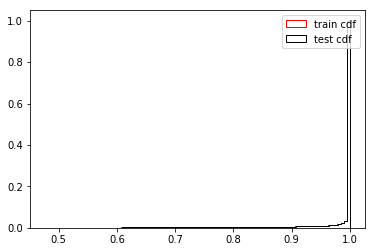

  4%|▍         | 19997/473047 [17:48<3:09:27, 39.85it/s] 

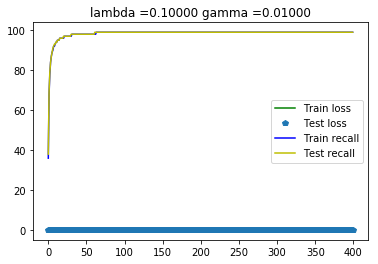

('Train cdfs: ', 0.4995549563758146)
('Test cdfs: ', 0.4995538202377721)
('Train scores unkown: ', array([0.49993682, 0.49361292], dtype=float32))
('Train scores train: ', array([0.9999654 , 0.99996746], dtype=float32))
('Test scores unkown: ', array([0.49993682, 0.49361292], dtype=float32))
('Test scores train: ', array([0.99996793, 0.9999701 ], dtype=float32))


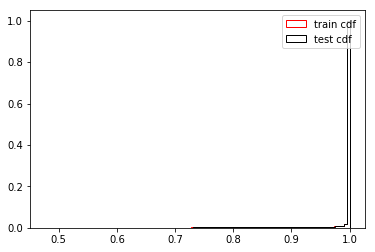

  6%|▋         | 29996/473047 [26:42<3:15:59, 37.68it/s] 

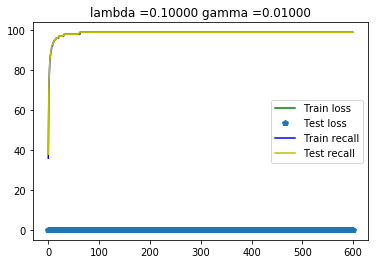

('Train cdfs: ', 0.4997072106079417)
('Test cdfs: ', 0.4997064816525928)
('Train scores unkown: ', array([0.49993682, 0.49361292], dtype=float32))
('Train scores train: ', array([0.9999801, 0.999979 ], dtype=float32))
('Test scores unkown: ', array([0.49993682, 0.49361292], dtype=float32))
('Test scores train: ', array([0.99998116, 0.9999759 ], dtype=float32))


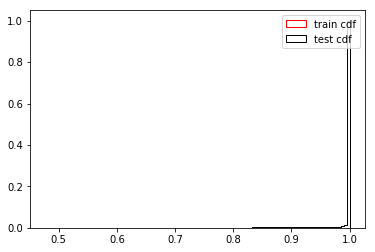

  8%|▊         | 39999/473047 [35:50<3:00:44, 39.93it/s] 

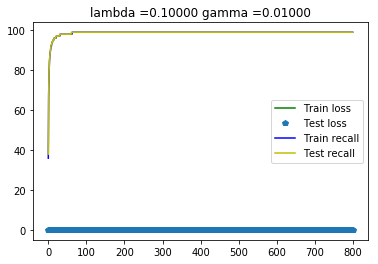

('Train cdfs: ', 0.499782430143172)
('Test cdfs: ', 0.49978188370511417)
('Train scores unkown: ', array([0.49993682, 0.49361292], dtype=float32))
('Train scores train: ', array([0.99998176, 0.999985  ], dtype=float32))
('Test scores unkown: ', array([0.49993682, 0.49361292], dtype=float32))
('Test scores train: ', array([0.99998295, 0.9999876 ], dtype=float32))


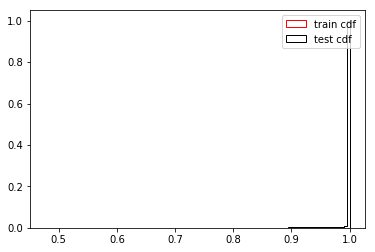

 11%|█         | 49999/473047 [45:56<2:55:18, 40.22it/s] 

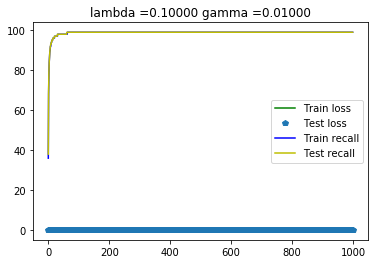

('Train cdfs: ', 0.4998271645020765)
('Test cdfs: ', 0.49982675592898307)
('Train scores unkown: ', array([0.49993682, 0.49361292], dtype=float32))
('Train scores train: ', array([0.99998784, 0.9999908 ], dtype=float32))
('Test scores unkown: ', array([0.49993682, 0.49361292], dtype=float32))
('Test scores train: ', array([0.99998784, 0.9999882 ], dtype=float32))


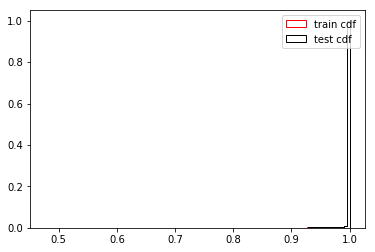

 13%|█▎        | 59998/473047 [55:19<2:58:09, 38.64it/s] 

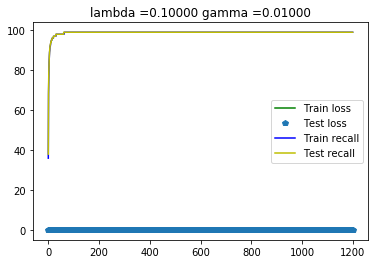

('Train cdfs: ', 0.4998568722379166)
('Test cdfs: ', 0.49985648444276537)
('Train scores unkown: ', array([0.49993682, 0.49361292], dtype=float32))
('Train scores train: ', array([0.9999882, 0.9999893], dtype=float32))
('Test scores unkown: ', array([0.49993682, 0.49361292], dtype=float32))
('Test scores train: ', array([0.9999927, 0.9999908], dtype=float32))


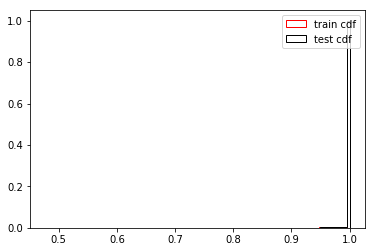

 15%|█▍        | 69996/473047 [1:04:50<2:53:14, 38.78it/s] 

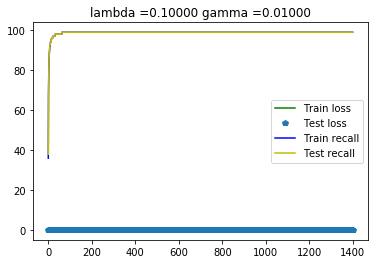

('Train cdfs: ', 0.49987778343619044)
('Test cdfs: ', 0.49987749170763496)
('Train scores unkown: ', array([0.49993682, 0.49361292], dtype=float32))
('Train scores train: ', array([0.9999925 , 0.99999416], dtype=float32))
('Test scores unkown: ', array([0.49993682, 0.49361292], dtype=float32))
('Test scores train: ', array([0.9999939, 0.9999931], dtype=float32))


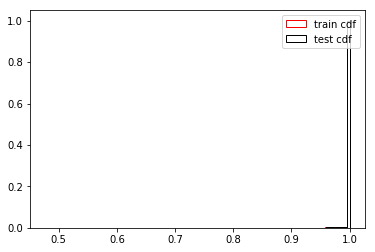

 17%|█▋        | 79996/473047 [1:14:24<3:09:39, 34.54it/s] 

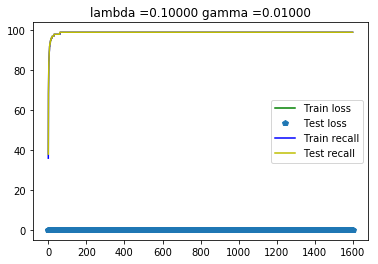

('Train cdfs: ', 0.499893551766822)
('Test cdfs: ', 0.4998932609940286)
('Train scores unkown: ', array([0.49993682, 0.49361292], dtype=float32))
('Train scores train: ', array([0.99999166, 0.99999464], dtype=float32))
('Test scores unkown: ', array([0.49993682, 0.49361292], dtype=float32))
('Test scores train: ', array([0.99999154, 0.99999285], dtype=float32))


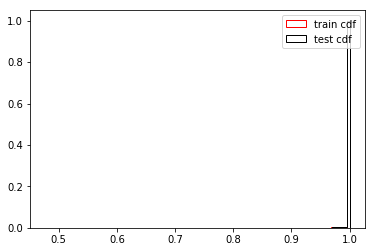

 19%|█▉        | 89995/473047 [1:24:10<2:53:46, 36.74it/s] 

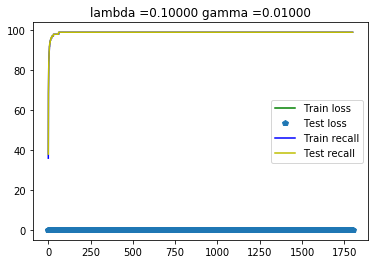

('Train cdfs: ', 0.49990576104421314)
('Test cdfs: ', 0.4999055341881066)
('Train scores unkown: ', array([0.49993682, 0.49361292], dtype=float32))
('Train scores train: ', array([0.9999937, 0.9999943], dtype=float32))
('Test scores unkown: ', array([0.49993682, 0.49361292], dtype=float32))
('Test scores train: ', array([0.9999913, 0.9999943], dtype=float32))


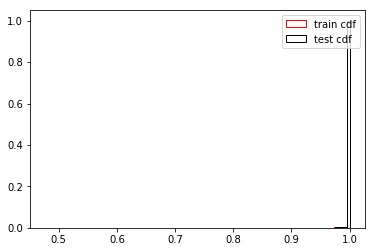

 21%|██        | 99997/473047 [1:33:49<2:44:54, 37.70it/s] 

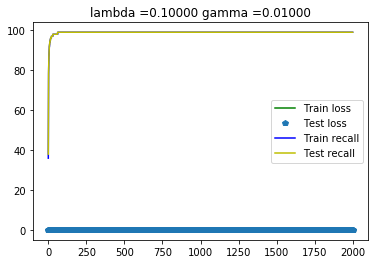

('Train cdfs: ', 0.4999154741623919)
('Test cdfs: ', 0.4999152415795014)
('Train scores unkown: ', array([0.49993682, 0.49361292], dtype=float32))
('Train scores train: ', array([0.99999523, 0.9999951 ], dtype=float32))
('Test scores unkown: ', array([0.49993682, 0.49361292], dtype=float32))
('Test scores train: ', array([0.99999535, 0.99999535], dtype=float32))


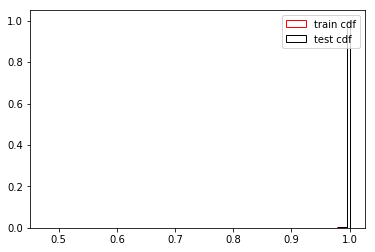

 23%|██▎       | 109995/473047 [1:43:39<2:46:47, 36.28it/s] 

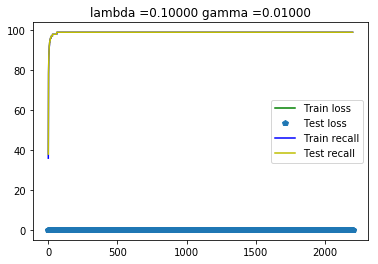

('Train cdfs: ', 0.49992340820778325)
('Test cdfs: ', 0.49992324846433195)
('Train scores unkown: ', array([0.49993682, 0.49361292], dtype=float32))
('Train scores train: ', array([0.999995, 0.999995], dtype=float32))
('Test scores unkown: ', array([0.49993682, 0.49361292], dtype=float32))
('Test scores train: ', array([0.9999949 , 0.99999535], dtype=float32))


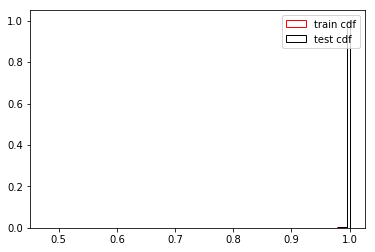

 25%|██▌       | 119996/473047 [1:53:30<2:48:22, 34.95it/s] 

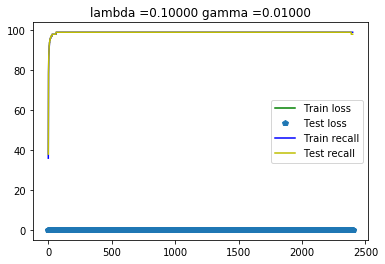

('Train cdfs: ', 0.49992987374619446)
('Test cdfs: ', 0.4999295589085573)
('Train scores unkown: ', array([0.49993682, 0.49361292], dtype=float32))
('Train scores train: ', array([0.99999547, 0.99999654], dtype=float32))
('Test scores unkown: ', array([0.49993682, 0.49361292], dtype=float32))
('Test scores train: ', array([0.9999962 , 0.99999416], dtype=float32))


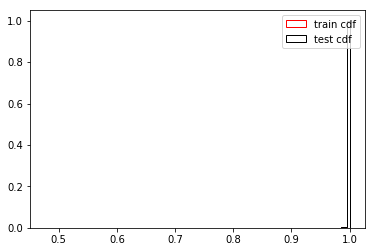

 27%|██▋       | 130000/473047 [2:03:51<2:11:11, 43.58it/s] 

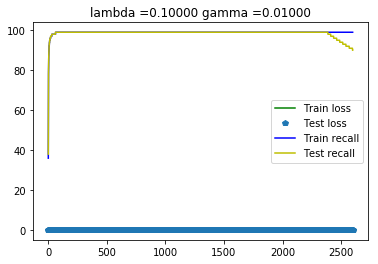

('Train cdfs: ', 0.49993521508516886)
('Test cdfs: ', 0.4999345995121882)
('Train scores unkown: ', array([0.49993682, 0.49361292], dtype=float32))
('Train scores train: ', array([0.9999974 , 0.99999523], dtype=float32))
('Test scores unkown: ', array([0.49993682, 0.49361292], dtype=float32))
('Test scores train: ', array([0.9999962 , 0.99999416], dtype=float32))


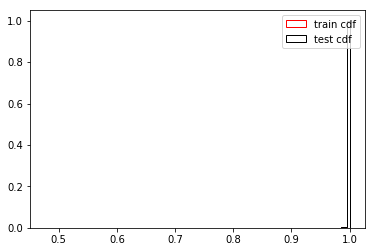

 30%|██▉       | 139996/473047 [2:12:33<2:22:53, 38.85it/s] 

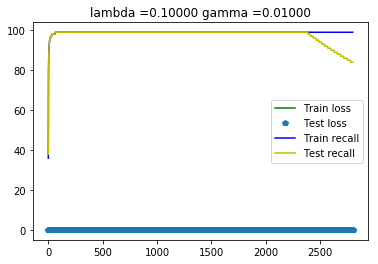

('Train cdfs: ', 0.4999397946082768)
('Test cdfs: ', 0.4999389258376349)
('Train scores unkown: ', array([0.49993682, 0.49361292], dtype=float32))
('Train scores train: ', array([0.9999962, 0.9999964], dtype=float32))
('Test scores unkown: ', array([0.49993682, 0.49361292], dtype=float32))
('Test scores train: ', array([0.9999962 , 0.99999416], dtype=float32))


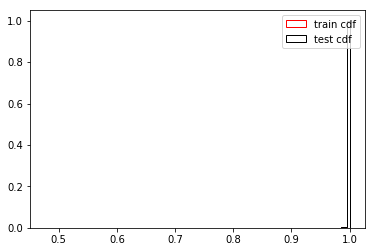

 32%|███▏      | 149997/473047 [2:21:25<2:34:23, 34.87it/s] 

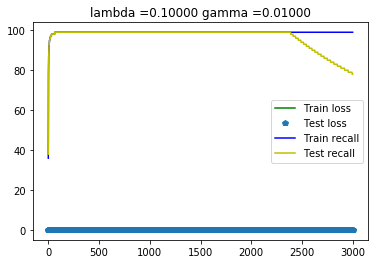

('Train cdfs: ', 0.4999438023424581)
('Test cdfs: ', 0.4999427491603262)
('Train scores unkown: ', array([0.49993682, 0.49361292], dtype=float32))
('Train scores train: ', array([0.99999666, 0.9999964 ], dtype=float32))
('Test scores unkown: ', array([0.49993682, 0.49361292], dtype=float32))
('Test scores train: ', array([0.9999962 , 0.99999416], dtype=float32))


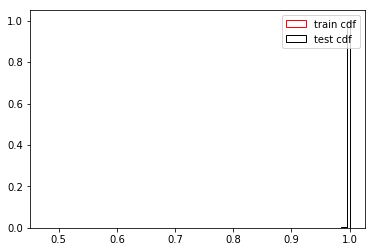

 34%|███▍      | 159995/473047 [2:30:26<2:25:24, 35.88it/s] 

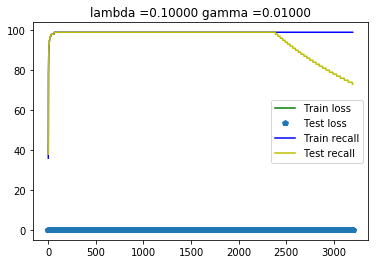

('Train cdfs: ', 0.49994730980877206)
('Test cdfs: ', 0.4999461220564765)
('Train scores unkown: ', array([0.49993682, 0.49361292], dtype=float32))
('Train scores train: ', array([0.9999963, 0.9999974], dtype=float32))
('Test scores unkown: ', array([0.49993682, 0.49361292], dtype=float32))
('Test scores train: ', array([0.9999962 , 0.99999416], dtype=float32))


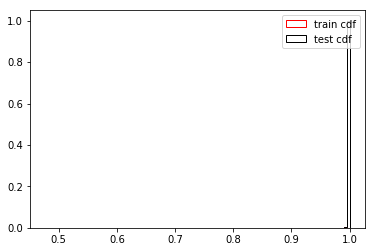

 36%|███▌      | 170000/473047 [2:40:02<2:12:59, 37.98it/s] 

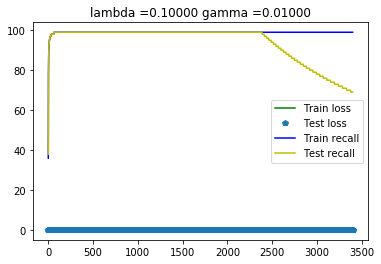

('Train cdfs: ', 0.49995040517360345)
('Test cdfs: ', 0.4999491540715955)
('Train scores unkown: ', array([0.49993682, 0.49361292], dtype=float32))
('Train scores train: ', array([0.99999714, 0.99999714], dtype=float32))
('Test scores unkown: ', array([0.49993682, 0.49361292], dtype=float32))
('Test scores train: ', array([0.9999962 , 0.99999416], dtype=float32))


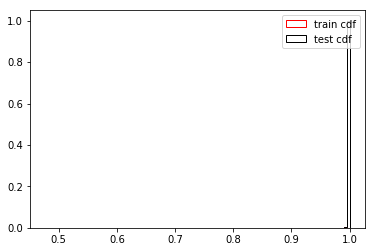

 38%|███▊      | 179995/473047 [2:50:33<2:16:00, 35.91it/s] 

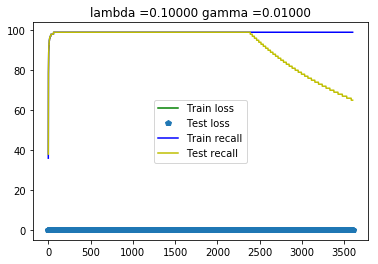

('Train cdfs: ', 0.499953188611479)
('Test cdfs: ', 0.4999518339632539)
('Train scores unkown: ', array([0.49993682, 0.49361292], dtype=float32))
('Train scores train: ', array([0.99999774, 0.9999962 ], dtype=float32))
('Test scores unkown: ', array([0.49993682, 0.49361292], dtype=float32))
('Test scores train: ', array([0.9999962 , 0.99999416], dtype=float32))


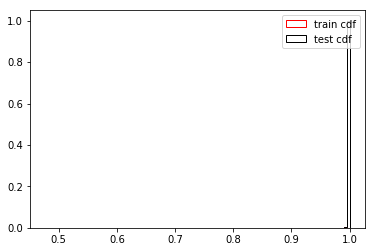

 40%|████      | 190000/473047 [3:00:49<1:53:16, 41.65it/s] 

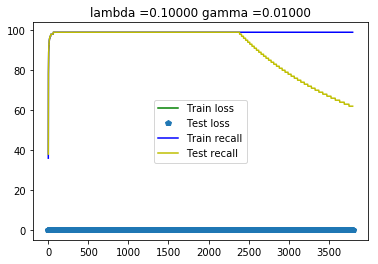

('Train cdfs: ', 0.49995564948097243)
('Test cdfs: ', 0.4999542455323526)
('Train scores unkown: ', array([0.49993682, 0.49361292], dtype=float32))
('Train scores train: ', array([0.9999974, 0.999998 ], dtype=float32))
('Test scores unkown: ', array([0.49993682, 0.49361292], dtype=float32))
('Test scores train: ', array([0.9999962 , 0.99999416], dtype=float32))


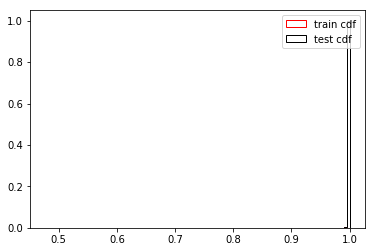

 40%|████      | 190728/473047 [3:01:35<4:01:17, 19.50it/s] 

In [ ]:
for g in range(len(gammas)):
    for l in range(len(lambdas)):
        train_losses = []
        train_recalls = []
        train_recall_outputs = [] 
        train_cdfs = []
        
        test_losses = []
        test_recalls = []
        test_recall_outputs = []
        test_cdfs = []
        
        eval_unknown_outputs = []
        
        model = SimpleConvNet()
        model.apply(weights_init)
        model.cuda()
        
        sgd(t=1, gamma=gammas[g], lamb=lambdas[l])
        
        j += 1